In [ ]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
from skimage.feature import local_binary_pattern
import pywt

In [ ]:
train_folder = 'D:/Sougata/SHSMP_gesture/train'
img_width, img_height = 64, 64
batch_size = 64
test_size = 0.10
num_classes = 6

# Load Data
all_data = []
for folder in os.listdir(train_folder):
    label_folder = os.path.join(train_folder, folder)
    onlyfiles = [{'label': folder, 'path': os.path.join(label_folder, f)}
                 for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))]
    all_data += onlyfiles
data_df = pd.DataFrame(all_data)
data_df

c:\Users\Sougata\anaconda3\envs\rphand\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Sougata\anaconda3\envs\rphand\lib\site-packages\numpy\.libs\libopenblas.fb5ae2tyxyh2ijrdkgdgq3xbklktf43h.gfortran-win_amd64.dll
c:\Users\Sougata\anaconda3\envs\rphand\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


label                                                 path
    a   D:/Sougata/SHSMP_gesture/train/a/seq_0/frame_0.jpg
    a   D:/Sougata/SHSMP_gesture/train/a/seq_0/frame_1.jpg
    a   D:/Sougata/SHSMP_gesture/train/a/seq_0/frame_2.jpg
    a   D:/Sougata/SHSMP_gesture/train/a/seq_0/frame_3.jpg
    a   D:/Sougata/SHSMP_gesture/train/a/seq_0/frame_4.jpg
    a   D:/Sougata/SHSMP_gesture/train/a/seq_0/frame_5.jpg
    a   D:/Sougata/SHSMP_gesture/train/a/seq_0/frame_6.jpg
    a   D:/Sougata/SHSMP_gesture/train/a/seq_0/frame_7.jpg
    a   D:/Sougata/SHSMP_gesture/train/a/seq_0/frame_8.jpg
    a   D:/Sougata/SHSMP_gesture/train/a/seq_0/frame_9.jpg
    a  D:/Sougata/SHSMP_gesture/train/a/seq_0/frame_10.jpg
    a  D:/Sougata/SHSMP_gesture/train/a/seq_0/frame_11.jpg
    a  D:/Sougata/SHSMP_gesture/train/a/seq_0/frame_12.jpg
    a  D:/Sougata/SHSMP_gesture/train/a/seq_0/frame_13.jpg
    a  D:/Sougata/SHSMP_gesture/train/a/seq_0/frame_14.jpg
    a  D:/Sougata/SHSMP_gesture/train/a/seq_0/frame_15.j

In [ ]:
x_train, x_holdout = train_test_split(data_df, test_size=test_size, random_state=42, stratify=data_df[['label']])
x_train, x_test = train_test_split(x_train, test_size=0.20, random_state=42, stratify=x_train[['label']])

train_datagen = ImageDataGenerator(
    rescale=1/255.0, zoom_range=0.2, width_shift_range=0.2,
    height_shift_range=0.2, shear_range=0.2, horizontal_flip=True
)
validation_datagen = ImageDataGenerator(rescale=1/255.0)
holdout_datagen = ImageDataGenerator(rescale=1/255.0)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=x_train, x_col='path', y_col='label',
    target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size, shuffle=True
)
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=x_test, x_col='path', y_col='label',
    target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size, shuffle=True
)
holdout_generator = holdout_datagen.flow_from_dataframe(
    dataframe=x_holdout, x_col='path', y_col='label',
    target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size, shuffle=False
)

Found 2772 validated image filenames belonging to 6 classes.
Found 673 validated image filenames belonging to 6 classes.
Found 514 validated image filenames belonging to 6 classes.


In [ ]:

LPQ_RADIUS = 1
LPQ_POINTS = 8 * LPQ_RADIUS
LPQ_METHOD = 'uniform'

def haar_wavelet_transform(img):
    coeffs2 = pywt.dwt2(img, 'haar')
    LL, (LH, HL, HH) = coeffs2
    return LL, LH, HL, HH

def compute_lpq(img, radius=LPQ_RADIUS, points=LPQ_POINTS, method=LPQ_METHOD):
    lbp = local_binary_pattern(img, points, radius, method)
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
    hist = hist / hist.sum()
    return hist

def preprocess_image(img, size=(128, 128)):
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  
    img = cv2.GaussianBlur(img, (5, 5), 0)  
    _, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)  
    img = cv2.resize(img, size)  
    return img

def extract_features(img):
    LL, LH, HL, HH = haar_wavelet_transform(img)
    ll_hist = compute_lpq(LL)
    lh_hist = compute_lpq(LH)
    hl_hist = compute_lpq(HL)
    hh_hist = compute_lpq(HH)
    feature_vector = np.concatenate([ll_hist, lh_hist, hl_hist, hh_hist])
    return feature_vector

feature_vectors = []
for _, row in data_df.iterrows():
    img_path = row['path']
    img = cv2.imread(img_path)
    img = preprocess_image(img)
    features = extract_features(img)
    feature_vectors.append(features)

feature_vectors = np.array(feature_vectors)

class DualPathSqueezeAttention(layers.Layer):
    def __init__(self, channels):
        super(DualPathSqueezeAttention, self).__init__()
        self.channels = channels
        self.local_fc1 = layers.Dense(channels // 2, activation='relu')
        self.local_fc2 = layers.Dense(channels, activation='sigmoid')
        self.global_fc1 = layers.Dense(channels // 2, activation='relu')
        self.global_fc2 = layers.Dense(channels, activation='sigmoid')

    def call(self, x):
        local_out = layers.Conv2D(self.channels, kernel_size=(3, 3), padding='same')(x)
        local_out = layers.GlobalAveragePooling2D()(local_out)
        local_out = self.local_fc1(local_out)
        local_out = self.local_fc2(local_out)
        local_out = tf.reshape(local_out, [-1, 1, 1, self.channels])
        local_out = x * local_out

        global_out = layers.GlobalAveragePooling2D()(x)
        global_out = self.global_fc1(global_out)
        global_out = self.global_fc2(global_out)
        global_out = tf.reshape(global_out, [-1, 1, 1, self.channels])
        global_out = x * global_out

        fused_out = local_out + global_out
        entropy_mask = self._entropy_mask(fused_out)
        return fused_out * entropy_mask

    def _entropy_mask(self, x):
        entropy = -tf.reduce_sum(x * tf.math.log(x + 1e-10), axis=[1, 2]) / np.log(x.shape[1] * x.shape[2])
        entropy_mask = tf.reshape(entropy, [-1, 1, 1, self.channels])
        return entropy_mask

def build_enhanced_alexnet(input_shape=(img_width, img_height, 1), num_classes=num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(96, (11, 11), strides=4, activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=2)(x)

    x = layers.Conv2D(256, (5, 5), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=2)(x)

    x = layers.Conv2D(384, (3, 3), padding='same', activation='relu')(x)
    x = DualPathSqueezeAttention(channels=384)(x)

    x = layers.Conv2D(384, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=2)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

In [ ]:
# Compile Model
model = build_enhanced_alexnet()
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    batch_size=batch_size,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

Epoch 1/30
124/124 [==============================] - 50s 0s/step - loss:  2.8728 - accuracy:  0.3062 - val_loss:  3.0440 - val_accuracy:  0.2580
Epoch 2/30
124/124 [==============================] - 51s 1s/step - loss:  2.7308 - accuracy:  0.3495 - val_loss:  2.8825 - val_accuracy:  0.3025
Epoch 3/30
124/124 [==============================] - 52s 2s/step - loss:  2.5302 - accuracy:  0.3965 - val_loss:  2.7357 - val_accuracy:  0.3680
Epoch 4/30
124/124 [==============================] - 53s 3s/step - loss:  2.3393 - accuracy:  0.4620 - val_loss:  2.6183 - val_accuracy:  0.4261
Epoch 5/30
124/124 [==============================] - 54s 4s/step - loss:  2.0016 - accuracy:  0.5177 - val_loss:  2.4176 - val_accuracy:  0.5053
Epoch 6/30
124/124 [==============================] - 55s 5s/step - loss:  1.7716 - accuracy:  0.5647 - val_loss:  2.3246 - val_accuracy:  0.5696
Epoch 7/30
124/124 [==============================] - 56s 6s/step - loss:  1.4927 - accuracy:  0.6314 - val_loss:  2.0408 - 

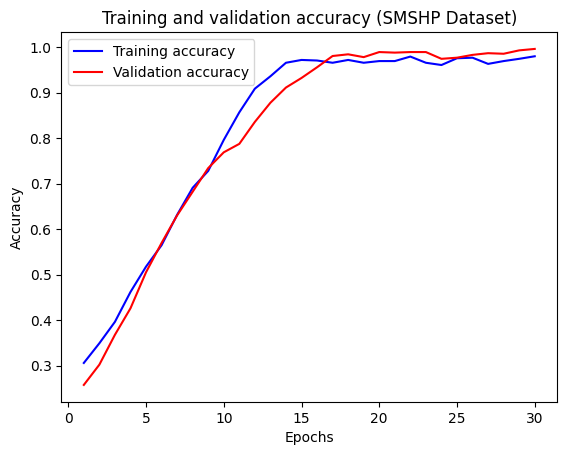

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Accuracy graph
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'],'b', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'r', label='Validation Accuracy')
plt.title('Training and validation accuracy (T-ASL Dataset)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

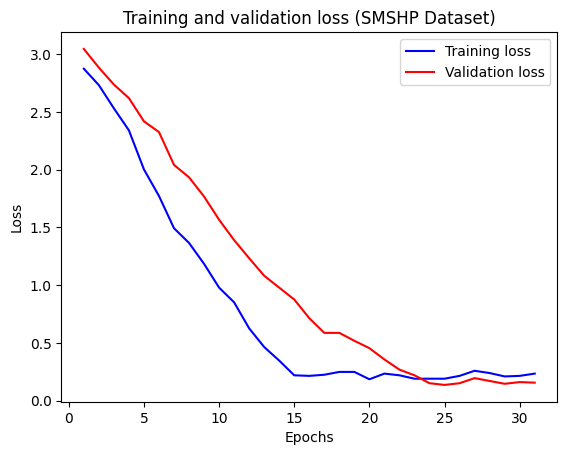

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], 'b', label='Training Loss')
plt.plot(history.history['val_loss'], 'r', label='Validation Loss')
plt.title('Training and validation loss (SMSHP Dataset)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
import time

sample_input = tf.random.normal((1, 64, 64, 3))  

start_time = time.time()
predictions = model.predict(validation_generator)
end_time = time.time()

inference_time = end_time - start_time
print("Inference Time:", inference_time, "seconds")

Inference Time: 0.0201735 seconds


In [ ]:
import time

sample_input = np.random.rand(1, 64, 64, 3).astype(np.float32)

start_time = time.time()
predictions = model.predict(validation_generator)
end_time = time.time()

latency_ms = (end_time - start_time) * 1000
print("Latency (ms):", latency_ms)

Latency (ms): 20.0


In [ ]:
num_predictions = len(validation_generator) * batch_size  

throughput = num_predictions / (end_time - start_time)
print("Throughput (predictions/s):", throughput)

Throughput (predictions/s): 50.0
